<h1>Data analysis of OpenBaltimore's calls for service dataset</h1>



<b>Members: Jerson Guansing, Daniel Jun, and Tae Song<br/>
Class: CMSC 455 - Numerical Computation<br/>
Instructor: Dr. Tyler Simon</b>


<h3>Abstract</h3>

Abstract goes here

Calls for service (911 calls) is an important service that can be a lifeline for some. There are concerns about staff shortage for 911 calls not being able to handle call volumes.

The goal / novelty of the project is to create a regression model or a function that can predict the call volume based on its priority, time of day,  longitude, latitude, etc., and 911 call centers can allocate more resources.

<h3>Introduction</h3>

Introduction goes here.

See <a href="https://data.baltimorecity.gov/">Open Baltimore</a> > <a href="https://data.baltimorecity.gov/browse?category=Public%20Safety">Public Safety</a> > <a href="https://data.baltimorecity.gov/Public-Safety/Calls-for-Service/xviu-ezkt">Calls for Service</a> for the dataset used for this project.


Add background information about Open Baltimore and the main goal of the intiative for transparency.

Also, the novelty of creating a regression model.



<h3>Methodology</h3>

<ul>
<li>OpenBaltimore dataset was used for this project.
<li>Python language is used.
<li>Jupyter Notebook is used for report, code and result integration.
<li>etc
</ul>

This section declares libaries and functions used through out the Jupyter notebook.

In [1]:
# import libraries
import pandas as pd
import time
import os
import re
import gc
from numpy.linalg import solve
import numpy as np
# libraries for plotting
%matplotlib inline
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
# libraries used for the decision tree and image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from IPython.display import Image
from sklearn import cross_validation

In [2]:
# function definitions
# We are dealing with a very large dataset which takes a lot of memory
# To avoid memory error, garbage collection is called often

daysInMonth = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

def dayOfYear(callDate):
    year, month, day = int(callDate[6:]), int(callDate[:2]), int(callDate[3:5])
    returnValue = day + sum(daysInMonth[0:month])
    returnValue += (1 if year % 4 == 0 and month > 2 else 0)
    if year % 4 == 0 and month > 2:
        returnValue += 1
    del year; del month; del day
    return returnValue

#function to print the total number of records in the dataset
def printTotal():
    #global df
    print("Total Records: " + str(len(df)))

# function to print the first 10 and the last 10 of a column
def print10(column, count = 10):
    print("\nColumn: " + column)
    uniqueEntries = sorted(df[column].unique())
    print("\nFirst " + str(count) + ": " + str(uniqueEntries[:count]))
    print("\nLast " + str(count) + ": " + str(uniqueEntries[-1*count:]))
    # free up memory
    del uniqueEntries
    gc.collect()

def printLength(column):
    uniqueEntries = df[column].apply(lambda x: len(x)).unique()
    print("\n" + column + " unique entry length: " + str(uniqueEntries))
    # free up memory
    del uniqueEntries
    gc.collect()
    
def printDiff(column):
    print("Total Records: " + str(len(df)))
    uniqueEntries = df[column].value_counts()
    print("Difference of total records and unique " + column + " entries: " + str(len(df) - sum(uniqueEntries)))
    print("Unique " + column + " entries: " + str(len(uniqueEntries)))
    print(uniqueEntries)
    # free up memory
    del uniqueEntries
    gc.collect()

# function to drop records in the dataset that are outliers
def dropRecords(column):
    # within 0.1% of the total records
    outlierThreshold = float(len(df) / 1000.0)
    temp = dict(df[column].value_counts())
    #map(lambda x: df.drop(df.index[df[column] == x], inplace=True) if temp[x] < outlierThreshold else continue, temp)
    for i in temp:
        # check if it is within the outlier threshold
        if temp[i] < outlierThreshold:
            # drop the outlier entries with the given parameter
            df.drop(df.index[df[column] == i], inplace=True)
    # free up space 
    del temp
    del outlierThreshold
    gc.collect()

def getErrors(x, y, coefficients):
    # get the computer y value with the given coefficients
    #y_computed = [ sum([ (i**j)*coefficients[j] for j in range(len(coefficients))]) for i in x ]
    y_computed = [ sum(i[j]*coefficients[j+1] for j in range(len(i)))+coefficients[0] for i in x]
    #print(y_computed)
    # absolute value of actual value - computer value
    absError = [ abs(y[i] - y_computed[i]) for i in range(len(y)) ]
    maxError = max(absError)
    avgError = sum(absError) / len(absError)
    #  sqrt(sum_over_set(absolute_error^2)/number_in_set)
    rmsError = (sum(map(lambda a: a**2, absError))/len(absError))**(1/2.0)
    del y_computed
    gc.collect()
    return maxError, avgError, rmsError

def getCoefficient(x, y, constantTerm = True):
    # Given numeric data points, find an equation that approximates the data with a least square fit
    # where x is not one dimensional
    # add one to one to include the constant term to make the fit
    # | SUM( 1* 1)  SUM( 1*X1)  SUM( 1*X2)  SUM( 1*X3) |   | Y0 |   | SUM( 1*Y) |
    # | SUM(X1* 1)  SUM(X1*X1)  SUM(X1*X2)  SUM(X1*X3) |   | a  |   | SUM(X1*Y) |
    # | SUM(X2* 1)  SUM(X2*X1)  SUM(X2*X2)  SUM(X2*X3) | x | b  | = | SUM(X2*Y) |
    # | SUM(X3* 1)  SUM(X3*X1)  SUM(X3*X2)  SUM(X3*X3) |   | c  |   | SUM(X3*Y) |
    n = len(x[0])
    if constantTerm == True:
        n += 1
    A = [ [0.0 for i in range(n) ] for j in range(n) ]
    Y = [ 0.0 for i in range(n) ]
    for i in range(n):
        if constantTerm == True:
            Y[i] = sum(map(lambda a,b: a[i - 1]*b if i > 0 else b, x, y))
            for j in range(n):
                A[i][j] = sum(map(lambda a: (a[i - 1] if i > 0 else 1)*(a[j - 1] if j > 0 else 1), x))
        else:
            Y[i] = sum(map(lambda a,b: a[i]*b, x, y))
            for j in range(n):
                A[i][j] = sum(map(lambda a: a[i]*a[j], x))
    return solve(A, Y)
    
def graphRelation(column1, column2):
    title = "\nDistribution based on " + column1 + " and " + column2
    print(title)
    X = list(df[column1].unique())
    Y = list(df[column2].unique())
    pathX, pathY, pathZ = [], [], []
    for i in X:
        outerColumn = df[df[column1] == i]
        for j in Y:
            pathX.append(i)
            pathY.append(j)
            pathZ.append(len(outerColumn[outerColumn[column2] == j]))
        del outerColumn
    fig = plt.figure()
    ax = fig.gca( projection='3d')
    plt.title(title)
    ax.set_xlim([min(X),max(X)])
    ax.set_ylim([min(Y),max(Y)])
    ax.set_xlabel(column1)
    ax.set_ylabel(column2)
    ax.set_zlabel("Call Volume")
    ax.scatter(pathX, pathY, pathZ, alpha=0.3)
    poly = getCoefficient([[x,y] for x,y in zip(pathX, pathY)], pathZ)
    print("Polynomial Coefficient")
    print(poly)
    errors = getErrors([[x,y] for x,y in zip(pathX, pathY)], pathZ, poly)
    print("Max Error: " + str(errors[0]),"Avg Error: " + str(errors[1]), "RMS Error: " + str(errors[2]))
    del title; del X; del Y
    del pathX; del pathY; del pathZ
    del fig; del ax; del poly; del errors
    gc.collect()

# function that plots the histogram (distribution) of a given column
def graphDistribution(column, width = -1):
    ax = plt.subplot()
    # Examine the distribution of the given column
    title = "\nDistribution based on " + column
    print(title)
    tempColumn = dict(df[column].value_counts())
    tempColumn2 = dict()
    valueList = [tempColumn[i] for i in tempColumn]
    # print(valueList)
    for i in tempColumn:
        try:
            float(i)
            break
        except ValueError:
            tempColumn2 = { i : valueList[i] for i in range(len(tempColumn)) }
            ax.set_xticklabels((i for i in tempColumn), rotation=45)
    if len(tempColumn2) > 0:
        tempColumn = tempColumn2
    if width > 0:
        ax.bar(tempColumn.keys(), tempColumn.values(), width)
    else:
        ax.bar(tempColumn.keys(), tempColumn.values())
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel("Frequency (count)")
    # free up space
    del tempColumn; del tempColumn2; del valueList
    del title; del ax
    gc.collect()


Import the dataset and convert it into a dataframe

In [3]:
# Dataset from Open Baltimore
fileName = "./Calls_for_Service.csv"
print("Looking for the data file " + fileName)
# download the dataset if the file is not found or less than 1mB
if not os.path.isfile(fileName) or os.path.getsize(fileName) < 10E5:
    print("Downloading the data file " + fileName + "...")
    time3 = time.clock()
    webAddress = "https://data.baltimorecity.gov/api/views/xviu-ezkt/rows.csv?accessType=DOWNLOAD"
    os.system("curl " + webAddress + " > " + fileName)
    time4 = time.clock()
    print("Download complete!")
    print("Time it took to download dataset: " + str(time4 - time3))
else:
    print("File size: " + str(os.path.getsize(fileName)) + " bytes")

Looking for the data file ./Calls_for_Service.csv
Download complete!
Time it took to download dataset: 112.0772180598958


In [4]:
# convert the file to a panda dataframe
print("Reading the data file...")
df = pd.read_csv(fileName)
print("Dataset imported!")

Reading the data file...
Dataset imported!


Display the first and last 50 entries to get an idea of the dataset's format.

In [5]:
df.head(10)

,callDateTime,priority,district,description,callNumber,incidentLocation,location
0,07/13/2015 10:41:00 AM,Medium,CD,SEE TEXT,P151941002,0 N CALVERT ST,"(39.2899299,-76.6123462)"
1,07/13/2015 10:47:00 AM,Medium,CD,911/NO VOICE,P151941003,600 E FAYETTE ST,"(39.2906737,-76.6071600)"
2,07/13/2015 10:42:00 AM,Medium,CD,911/NO VOICE,P151941004,200 E BALTIMORE ST,"(39.2898910,-76.6120720)"
3,07/13/2015 10:45:00 AM,Low,CD,PRKG COMPLAINT,P151941005,800 PARK AV,"(39.2985163,-76.6184754)"
4,07/13/2015 10:46:00 AM,Medium,SW,AUTO THEFT,P151941006,3500 CLIFTON AV,"(39.3112130,-76.6763150)"
5,07/13/2015 10:47:00 AM,Medium,ND,FAMILY DISTURB,P151941007,2700 N CALVERT ST,"(39.3208510,-76.6147390)"
6,07/13/2015 10:46:00 AM,High,WD,SILENT ALARM,P151941008,2100 W NORTH AV,"(39.3097096,-76.6513109)"
7,07/13/2015 10:49:00 AM,Low,SW,AUTO ACCIDENT,P151941010,3100 WILKENS AV,"(39.2756929,-76.6664179)"
8,07/13/2015 10:48:00 AM,Medium,NE,FAMILY DISTURB,P151941011,4800 GILRAY DR,"(39.3483090,-76.5768440)"
9,07/13/2015 10:49:00 AM,Medium,ND,NARCOTICSOutside,P151941012,W GARRISON AV/PIMLICO RD,"(39.349653,-76.669145)"


In [6]:
df.tail(10)

,callDateTime,priority,district,description,callNumber,incidentLocation,location
1876270,10/02/2016 04:28:00 PM,Low,ND,DOG BITE,P162761905,2400 W BELVEDERE AV,"(39.3549016,-76.6622292)"
1876271,10/02/2016 04:28:00 PM,Low,NE,NOTIFY,P162762009,6100 GLENOAK AV,"(39.3564630,-76.5500340)"
1876272,10/02/2016 03:31:00 PM,Non-Emergency,SD,PRKG COMPLAINT,P162761659,1100 DEXTER ST,"(39.2809211,-76.6299317)"
1876273,10/02/2016 03:32:00 PM,Non-Emergency,SW,FOLLOW UP,P162761661,2000 HARMAN AV,"(39.2658270,-76.6510690)"
1876274,10/02/2016 03:34:00 PM,Low,NW,LARCENY F/AUTO,P162761666,3700 CHATHAM RD,"(39.3296140,-76.6780859)"
1876275,10/02/2016 03:49:00 PM,Non-Emergency,WD,FOLLOW UP,P162761696,1600 N FULTON AV,"(39.3066784,-76.6463211)"
1876276,10/02/2016 03:48:00 PM,Non-Emergency,NE,STREET OBSTRUCT,P162761698,5900 BLK GLENFALLS AV,"(39.3464940,-76.5425099)"
1876277,10/02/2016 03:50:00 PM,Medium,SD,NARCOTICS INSIDE,P162761699,0 CHERRY HILL RD,"(39.2528897,-76.6162673)"
1876278,10/02/2016 03:53:00 PM,High,CD,RA POLICE,P162761706,1700 MARYLAND AV,"(39.3090739,-76.6178128)"
1876279,10/02/2016 04:05:00 PM,High,ND,RA POLICE,P162761727,700 MCKEWIN AV,"(39.3330153,-76.6058973)"


In [7]:
# Start first by checking the general description of the dataset using the describe function
df.describe()

,callDateTime,priority,district,description,callNumber,incidentLocation,location
count,1876280,1869625,1876280,1876280,1876280,1876280,1876280
unique,747584,6,18,6229,1876280,66935,28852
top,05/02/2015 11:48:00 PM,Medium,NE,911/NO VOICE,P152683620,100,"(,)"
freq,14,938455,279259,318178,1,30958,66429


Start cleaning the data and manipulate it to a format that can be used in a numerical analysis.

In [8]:
# Now work on the priority column. Manipulate and clean the data
# If you examine the df.describe() output up top, the total record count doesn't match the priority count entries.
printDiff("priority")

Total Records: 1876280
Difference of total records and unique priority entries: 6655
Unique priority entries: 6
Medium            938455
Low               435937
High              282878
Non-Emergency     210991
Emergency            709
Out of Service       655
Name: priority, dtype: int64


In [9]:
# this means there are records that are missing a priority value.
# replace the null with Unknown
df["priority"].fillna("Unknown", inplace=True)
printDiff("priority")

Total Records: 1876280
Difference of total records and unique priority entries: 0
Unique priority entries: 7
Medium            938455
Low               435937
High              282878
Non-Emergency     210991
Unknown             6655
Emergency            709
Out of Service       655
Name: priority, dtype: int64


Time it took to run: 1.0317366742564786
Total Records: 1874916
Difference of total records and unique priority entries: 0
Unique priority entries: 5
Medium           938455
Low              435937
High             282878
Non-Emergency    210991
Unknown            6655
Name: priority, dtype: int64

Distribution based on priority


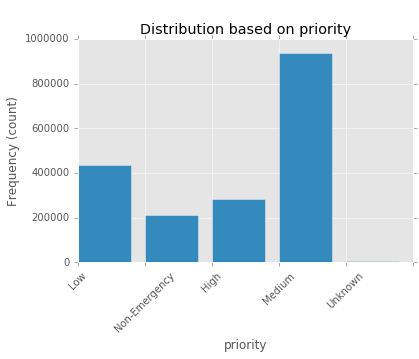

In [10]:
# Drop all the outliers based on priority
time1 = time.clock()
dropRecords("priority")
time2 = time.clock()
print("Time it took to run: " + str(time2-time1))
printDiff("priority")
graphDistribution("priority")

# convert priority to numeric values
priority = list(df["priority"].unique())
df["priority"] = df["priority"].apply(lambda y: priority.index(y))

In [11]:
# check the and manipulate the location column
print10("location")


Column: location

First 10: ['(', '(,)', '(-76.544666,-76.544666)', '(-76.559772,76.309639)', '(-76.564171,-76.564171)', '(0,0)', '(0.000000,0.000000)', '(11.5878315,106.2367696)', '(21.9149693,-79.3691450)', '(22.9517953,-82.2920662)']

Last 10: ['(39.8632896,-86.0810317)', '(42.7045803,-82.7485949)', '(42.8339853,-106.2568759)', '(43.3623364,-8.4115940)', '(44.6284464,20.5596578)', '(51.2145255,4.4731932)', '(51.4556432,7.0115552)', '(531707,900599)', '(58.6801204,14.1047864)', '(7.2663850,44.0431447)']


In [12]:
# drop the records without numeric entries
df.drop(df.index[df.location == "("], inplace=True)
df.drop(df.index[df.location == "(,)"], inplace=True)

In [13]:
# The location column contains the longitude and latitude
# We are going to separate it into two columns
# convert the location column into the longitude column
# rounding the values to lower variability
df["longitude"] = df["location"].apply(lambda x: round(float(x[1: x.index(",")]), 3))
# check if there are records with null value or nan
printDiff("longitude")

Total Records: 1808586
Difference of total records and unique longitude entries: 0
Unique longitude entries: 273
 39.290        53866
 39.291        46704
 39.296        35894
 39.293        35552
 39.287        35176
 39.289        34685
 39.310        34062
 39.300        32983
 39.299        31815
 39.381        30933
 39.286        30873
 39.292        30786
 39.288        30118
 39.311        30076
 39.294        29620
 39.297        29328
 39.295        29197
 39.309        27455
 39.302        26785
 39.285        25490
 39.283        24750
 39.281        24269
 39.312        23719
 39.305        23562
 39.324        22812
 39.317        21940
 39.323        21706
 39.307        21625
 39.303        21451
 39.301        21178
               ...  
 39.457            1
 39.408            1
 39.389            1
 35.033            1
 39.386            1
 39.541            1
 39.388            1
 39.137            1
 38.982            1
 33.849            1
 39.435            1
 39.4

In [14]:
#df.loc[(df.longitude == 39.290) & (df.priority == 1) ].count
# Make sure there are no entries with 0.00 longitude
df.drop(df.index[df.longitude == 0.00], inplace=True)

time1 = time.clock()
dropRecords("longitude")
time2 = time.clock()
print("Time it took to run: " + str(time2-time1))

Time it took to run: 55.3595172335709


In [15]:
# Make sure there are no entries with 0.00 longitude
df.drop(df.index[df.longitude == 0.00], inplace=True)

time1 = time.clock()
dropRecords("longitude")
time2 = time.clock()
print("Time it took to run: " + str(time2-time1))

Time it took to run: 0.17496033236460562


Time it took to run: 0.17310484604274734
Total Records: 1775529
Difference of total records and unique longitude entries: 0
Unique longitude entries: 133
39.290    53866
39.291    46704
39.296    35894
39.293    35552
39.287    35176
39.289    34685
39.310    34062
39.300    32983
39.299    31815
39.381    30933
39.286    30873
39.292    30786
39.288    30118
39.311    30076
39.294    29620
39.297    29328
39.295    29197
39.309    27455
39.302    26785
39.285    25490
39.283    24750
39.281    24269
39.312    23719
39.305    23562
39.324    22812
39.317    21940
39.323    21706
39.307    21625
39.303    21451
39.301    21178
          ...  
39.364     4047
39.235     3905
39.366     3744
39.226     3726
39.371     3633
39.263     3531
39.249     3385
39.230     3373
39.267     3335
39.251     3314
39.372     3223
39.370     3197
39.266     3191
39.369     3135
39.271     3063
39.237     3031
39.270     2828
39.234     2660
39.228     2591
39.233     2578
39.264     2558
39.252     237

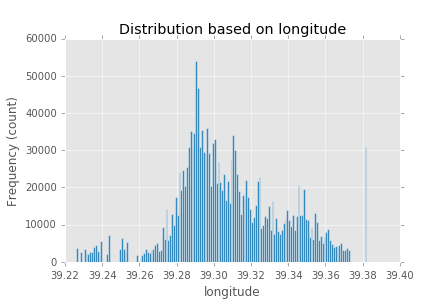

In [16]:
# Make sure there are no entries with 0.00 longitude
df.drop(df.index[df.longitude == 0.00], inplace=True)

# Drop all the outliers based on longitude
time1 = time.clock()
dropRecords("longitude")
time2 = time.clock()
print("Time it took to run: " + str(time2-time1))
printDiff("longitude")
graphDistribution("longitude", 0.001)


Distribution based on priority and longitude
Polynomial Coefficient
[-162744.66239122   -1504.35413534    4284.98597605]
Max Error: 29196.6920744 Avg Error: 1904.74618546 RMS Error: 3188.94129038


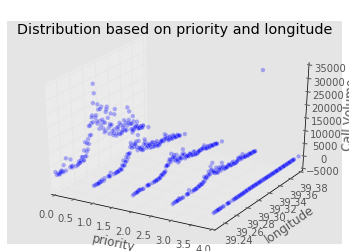

In [17]:
# This will graph the call volume(count) given the priority and longitude of the record
graphRelation("priority", "longitude")


In [18]:
# convert the location column into the latitude column
# rounding the values to lower variability
df["latitude"] = df["location"].apply(lambda x: round(float(x[x.index(",")+1:x.index(")")]), 3))
# check if there are records with null value or nan
printDiff("latitude")

Total Records: 1775529
Difference of total records and unique latitude entries: 0
Unique latitude entries: 239
-76.612    39821
-76.657    37071
-76.607    36759
-76.610    30920
-76.594    26548
-76.609    22922
-76.615    21992
-76.652    20994
-76.636    20008
-76.603    19218
-76.573    19194
-76.595    18952
-76.608    18688
-76.592    18632
-76.611    18400
-76.630    18272
-76.616    17892
-76.647    17872
-76.683    17827
-76.600    17589
-76.598    17470
-76.614    16903
-76.650    16825
-76.621    15525
-76.613    15471
-76.601    15070
-76.645    15065
-76.632    14809
-76.634    14787
-76.599    14521
           ...  
-76.516        4
-76.747        3
-76.727        2
-76.508        2
-76.746        2
-76.724        2
-76.441        2
-76.517        2
-76.526        2
-76.729        2
-76.772        1
-76.755        1
 39.241        1
 39.346        1
-76.442        1
-76.524        1
-77.020        1
-76.491        1
-76.764        1
-76.520        1
-76.914        1
-76.7

Time it took to run: 23.172741446560906
Total Records: 1769954
Difference of total records and unique latitude entries: 0
Unique latitude entries: 182
-76.612    39821
-76.657    37071
-76.607    36759
-76.610    30920
-76.594    26548
-76.609    22922
-76.615    21992
-76.652    20994
-76.636    20008
-76.603    19218
-76.573    19194
-76.595    18952
-76.608    18688
-76.592    18632
-76.611    18400
-76.630    18272
-76.616    17892
-76.647    17872
-76.683    17827
-76.600    17589
-76.598    17470
-76.614    16903
-76.650    16825
-76.621    15525
-76.613    15471
-76.601    15070
-76.645    15065
-76.632    14809
-76.634    14787
-76.599    14521
           ...  
-76.535     4017
-76.543     3982
-76.551     3957
-76.557     3956
-76.561     3901
-76.698     3837
-76.554     3768
-76.537     3706
-76.560     3693
-76.542     3611
-76.546     3581
-76.531     3471
-76.534     3451
-76.706     3326
-76.702     3271
-76.701     3211
-76.540     3206
-76.709     2987
-76.539     2960

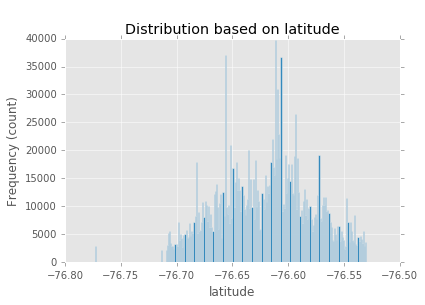

In [19]:
# Make sure there are no entries with 0.00 latitude
df.drop(df.index[df.latitude == 0.00], inplace=True)

# Drop all the outliers based on latitude
time1 = time.clock()
dropRecords("latitude")
time2 = time.clock()
print("Time it took to run: " + str(time2-time1))
printDiff("latitude")
graphDistribution("latitude", 0.001)

We already have longitude and latitude columns that can be used for our data model.


Distribution based on priority and latitude
Polynomial Coefficient
[ 75513.99847885  -1095.85824176    931.55250185]
Max Error: 30388.5963811 Avg Error: 1084.24441378 RMS Error: 2074.7895949


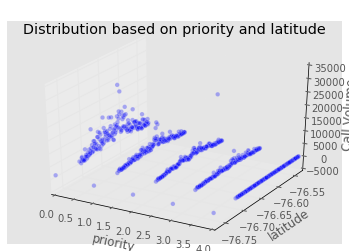

In [20]:
# This will graph the call volume(count) given the priority and latitude
graphRelation("priority", "latitude")


Distribution based on longitude and latitude
Polynomial Coefficient
[-1850.24001485   117.20298746    35.0207759 ]
Max Error: 30851.2567843 Avg Error: 104.478110142 RMS Error: 375.74648923


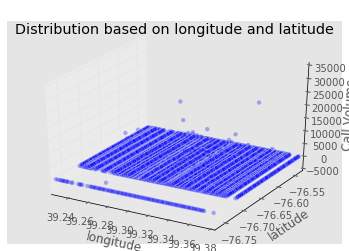

In [21]:
# This will graph the call volume(count) given the longitude and latitude
graphRelation("longitude", "latitude")

In [22]:
temp1 = list(df["priority"].unique())
temp2 = list(df["longitude"].unique())
temp3 = list(df["latitude"].unique())

In [26]:
time1 = time.clock()
xy = [ [[i,j,k], len(df[(df.priority == i) & (df.longitude == j) & (df.latitude == k)])] for k in temp3 for j in temp2 for i in temp1 ]
time2 = time.clock()
print("Time it took to run: " + str(time2-time1))
xy

Time it took to run: 2190.3007982279705


[[[0, 39.289999999999999, -76.611999999999995], 12827],
 [[1, 39.289999999999999, -76.611999999999995], 4453],
 [[2, 39.289999999999999, -76.611999999999995], 2394],
 [[3, 39.289999999999999, -76.611999999999995], 1618],
 [[4, 39.289999999999999, -76.611999999999995], 72],
 [[0, 39.290999999999997, -76.611999999999995], 3973],
 [[1, 39.290999999999997, -76.611999999999995], 1592],
 [[2, 39.290999999999997, -76.611999999999995], 344],
 [[3, 39.290999999999997, -76.611999999999995], 266],
 [[4, 39.290999999999997, -76.611999999999995], 5],
 [[0, 39.298999999999999, -76.611999999999995], 319],
 [[1, 39.298999999999999, -76.611999999999995], 95],
 [[2, 39.298999999999999, -76.611999999999995], 103],
 [[3, 39.298999999999999, -76.611999999999995], 20],
 [[4, 39.298999999999999, -76.611999999999995], 3],
 [[0, 39.311, -76.611999999999995], 267],
 [[1, 39.311, -76.611999999999995], 153],
 [[2, 39.311, -76.611999999999995], 104],
 [[3, 39.311, -76.611999999999995], 25],
 [[4, 39.311, -76.61199

In [27]:
len(xy)

121030

In [28]:
testcoef = getCoefficient(np.array(xy)[:,0], np.array(xy)[:,1])
print("Polynomial Coefficients")
print(testcoef)
print("Max Error","Avg Error", "RMS Error")
print(getErrors(np.array(xy)[:,0],np.array(xy)[:,1], testcoef))

Polynomial Coefficients
[-353.5681065    -8.23953565   23.44059163    7.00416294]
Max Error Avg Error RMS Error
(30677.090893218679, 21.810909351259102, 138.25514821456238)


In [29]:
gc.collect()
# check and manipulate the description column
# Based on the describe output above, there are about 6000 unique descriptions
print10("description")


Column: description

First 10: ['&  75', '& 28', '& 30', '& 4E', '& 55A', '& 59', '& 5G', '& 6J', '& 75', '& 7C']

Last 10: ['YP', 'Z', '[', ']LLEGAL DUMPING', '`', '`INVEST', '`INVESTIGATE', '`UNKNOWN TROUBLE', 'iNVESTIGATE', 'tEST CALL']


In [16]:
# cleaning up the description column
# removing unnecessary characters
df["description"] = df["description"].apply(lambda x: re.sub("(-|'|,|=|\[|\]|;|\@|`|\$|\\|\(|\)|\+|/|\s|\*|\&|\.|#|\?)", "", x))
# check if there are records with null value or nan
printDiff("description")

Total Records: 1762769
Difference of total records and unique description entries: 0
Unique description entries: 4625
911NOVOICE          310737
DISORDERLY          149436
TrafficStop         103282
COMMONASSAULT        72793
AUTOACCIDENT         65778
NARCOTICSOutside     56447
SILENTALARM          48558
FAMILYDISTURB        42694
OTHER                41209
RepairsService       40868
INVESTIGATE          40752
BURGLARY             34395
HITANDRUN            32078
LARCENCY             28286
911NoVoice           26469
FieldInterview       23412
DESTRUCTPROPTY       22134
SUSPICIOUSPERS       20742
LARCENYFAUTO         18720
LabRequest           18442
FootPatrol           17538
AUTOTHEFT            17157
Transport            16406
AUTOACCINJURY        16192
Other                15461
RAPOLICE             15326
WANTEDONWARR         14436
PrivateTow           13166
LOUDMUSIC            12974
ARMEDPERSON          12885
                     ...  
UNAUTHVEHICLE            1
POSSLOSTLADY      

In [17]:
# There are still a lot of unique descriptions
# more cleaning for the description entries
# remove the nonnumeric characters for entries that are preceded with numbers
# leave entries as is for nonnumeric only and numeric only
df["description"] = df["description"].apply(lambda  x: re.search("\d+", x).group(0).upper() if re.match("(?:\d+)\D+", x) else x.upper() )
# check if there are records with null value or nan
printDiff("description")

Total Records: 1762769
Difference of total records and unique description entries: 0
Unique description entries: 4455
911                 340012
DISORDERLY          158699
TRAFFICSTOP         103282
COMMONASSAULT        77644
AUTOACCIDENT         69665
NARCOTICSOUTSIDE     58872
OTHER                56670
SILENTALARM          53396
FAMILYDISTURB        46499
REPAIRSSERVICE       40868
INVESTIGATE          40753
BURGLARY             36999
HITANDRUN            34197
LARCENCY             28286
DESTRUCTPROPTY       23760
FIELDINTERVIEW       23412
SUSPICIOUSPERS       21943
LARCENYFAUTO         19802
LABREQUEST           18442
AUTOTHEFT            18206
FOOTPATROL           17538
AUTOACCINJURY        16929
TRANSPORT            16487
WANTEDONWARR         15827
RAPOLICE             15326
LOUDMUSIC            13742
ARMEDPERSON          13527
PRIVATETOW           13169
MISSINGPERSON        12369
AGGRAVASSAULT        12341
                     ...  
INVESTIGATE33            1
DSABLEVEHICLE     

The description column is all over the place (too inconsistent). There isn't really an efficient way of shrinking the variability size suitable for the data model.


Now, work on the callDateTime column.
From the general description, there are over 1.8 million calls.

The callDateTime column is a string with the following format mm/dd/yyyy hh:mm:ss AM/PM. We need to verify if the format is consistent through out the whole dataset. Afterwards, extract just the data we need.


In [19]:
# start exploring the callDateTime column
# find out the string length of the entries
printLength("callDateTime")


callDateTime length: [22]


In [20]:
# callDateTime are all the same length
# Start manipulating/cleaning the data
# separate the call date
df["callDate"] = df["callDateTime"].apply(lambda x: x[:10] )
# check the first 10 and the last 10 unique values
print10("location")
# check the length
printLength("callDate")
# Check the variability of the callDate column
printDiff("callDate")


Column: location

First 10: ['(39.2256170,-76.5999820)', '(39.225763,-76.613400)', '(39.2258440,-76.5903320)', '(39.225956,-76.590064)', '(39.226041,-76.588529)', '(39.2260465,-76.5885463)', '(39.226082,-76.592301)', '(39.226131,-76.586913)', '(39.2261328,-76.5943905)', '(39.2261351,-76.5943547)']

Last 10: ['(39.3721025,-76.5526561)', '(39.3721105,-76.5790595)', '(39.3721109,-76.6381076)', '(39.3721170,-76.5962570)', '(39.372360,-76.582040)', '(39.3723999,-76.5821688)', '(39.3724180,-76.5674334)', '(39.3724183,-76.5674333)', '(39.3810499,-76.6572571)', '(39.381219,-76.673348)']

callDate length: [10]
Total Records: 1762769
Difference of total records and unique callDate entries: 0
Unique callDate entries: 638
04/28/2015    4396
07/02/2015    3434
04/25/2016    3360
10/08/2015    3357
04/18/2015    3353
03/24/2016    3342
07/03/2015    3337
08/11/2015    3329
10/23/2015    3328
06/26/2015    3328
08/27/2015    3295
07/31/2015    3292
07/04/2015    3289
04/26/2016    3289
06/19/2015   

That is a lot of unique values. Need to try and reduce it further.

Also, we need to convert the date (string) into a numeric value.

We can see the frequency of calls based on month by creating the callMonth column.

Total Records: 1762769
Difference of total records and unique callMonth entries: 0
Unique callMonth entries: 12
07    183670
08    180306
06    180028
05    177094
04    174626
09    169372
03    168965
01    141190
02    136007
10     86815
12     83272
11     81424
Name: callMonth, dtype: int64

Distribution based on callMonth


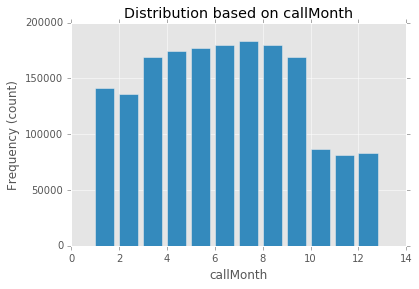

In [21]:
# create the callMonth column
df["callMonth"] = df["callDate"].apply(lambda x: x[:2])
# Check the variability of the callMonth column
printDiff("callMonth")
graphDistribution("callMonth")

For a higher resolution than callMonths, we can also create a column that determines what day of the year (1 to 365 or 366 in a leap year) the called was made to find patterns on which days get the highest frequency of calls.

Total Records: 1762769
Difference of total records and unique callDayOfYear entries: 0
Unique callDayOfYear entries: 365
118    7488
183    6536
148    6373
149    6326
212    6314
156    6284
254    6270
184    6262
210    6260
239    6242
240    6238
169    6236
146    6231
185    6230
211    6218
91     6216
173    6212
223    6208
177    6202
180    6199
181    6190
147    6189
93     6189
175    6185
224    6182
106    6182
160    6176
92     6172
170    6164
140    6162
       ... 
341    2648
319    2638
300    2638
362    2629
357    2627
339    2621
356    2619
361    2619
364    2618
353    2608
328    2595
347    2569
299    2565
292    2562
342    2528
331    2514
326    2486
340    2477
329    2477
312    2451
334    2450
327    2446
354    2375
360    2347
333    2340
291    2302
359    2279
330    2119
284    2001
283    1242
Name: callDayOfYear, dtype: int64

Distribution based on callDayOfYear


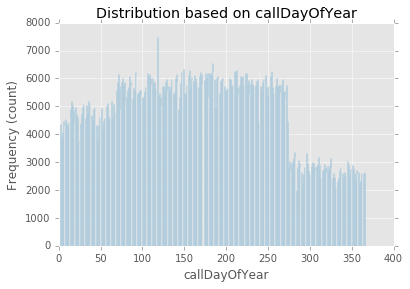

In [22]:
# create the callDayOfYear column
df["callDayOfYear"] = df["callDate"].apply(lambda x: dayOfYear(x))
# Check the variability of the callDayOfYear column
printDiff("callDayOfYear")
graphDistribution("callDayOfYear")

Another data that can be extracted from the callDateTime column is the time the call was received.

In [23]:
# separate the call time from the callDateTime column
# the format is hh:mm:ss AM/PM (string) converted to hh:mm (24 hour format numeric)
df["callTime"] = df["callDateTime"].apply(lambda x: (str(int(x[11:13]) + 12) if x[11:13] != "12" else "00") + ":" + x[14:16] if x[20:].upper() == "PM" else x[11:13] + ":" + x[14:16])
# check the first 10 and the last 10 unique values
print10("callTime")
# check the length
printLength("callTime")
# Check the variability of the callTime column
printDiff("callTime")


Column: callTime

First 10: ['00:00', '00:01', '00:02', '00:03', '00:04', '00:05', '00:06', '00:07', '00:08', '00:09']

Last 10: ['23:50', '23:51', '23:52', '23:53', '23:54', '23:55', '23:56', '23:57', '23:58', '23:59']

callTime length: [5]
Total Records: 1762769
Difference of total records and unique callTime entries: 0
Unique callTime entries: 1440
17:24    1969
17:20    1951
17:19    1940
18:09    1939
17:17    1938
18:07    1929
17:16    1923
17:15    1920
17:23    1919
17:27    1918
17:18    1914
18:08    1907
17:47    1904
16:09    1901
17:13    1900
17:28    1895
17:25    1895
16:54    1892
18:17    1890
17:11    1888
17:12    1888
17:22    1886
17:14    1884
17:48    1881
16:53    1875
17:10    1864
17:30    1863
18:51    1859
18:10    1859
17:29    1859
         ... 
04:57     373
04:44     372
05:14     371
04:43     371
05:33     371
05:55     371
04:26     371
05:49     370
05:24     370
05:17     369
06:00     369
05:36     368
05:28     367
05:35     365
05:07     364
0

Again, the data is in time format and must be converted to a numeric format.

We can create the callHour column to to assess the frequency of calls based on the hour of day.

Total Records: 1762769
Difference of total records and unique callHour entries: 0
Unique callHour entries: 24
17    109291
18    106141
16    104094
15    100514
19     99979
14     99973
20     98194
21     95047
13     91565
0      89458
11     87062
22     85124
10     79760
23     75873
9      71613
8      63439
12     62998
1      50177
7      44167
2      41688
3      31179
6      27919
4      24663
5      22851
Name: callHour, dtype: int64

Distribution based on callHour


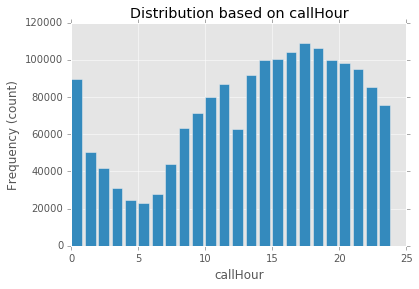

In [24]:
# callTime has too much entry/variability 
# try to lower it by creating the callHour column
df["callHour"] = df["callTime"].apply(lambda x: int(x[:2]))
# Check the variability of the callHour column
printDiff("callHour")
graphDistribution("callHour")

For a higher resolution, we can create callTimeOfDay to indicate the exact time when the call was received. Convert callTime into a numeric value in minutes unit.

Total Records: 1762769
Difference of total records and unique callTimeOfDay entries: 0
Unique callTimeOfDay entries: 1440
1044    1969
1040    1951
1039    1940
1089    1939
1037    1938
1087    1929
1036    1923
1035    1920
1043    1919
1047    1918
1038    1914
1088    1907
1067    1904
969     1901
1033    1900
1045    1895
1048    1895
1014    1892
1097    1890
1032    1888
1031    1888
1042    1886
1034    1884
1068    1881
1013    1875
1030    1864
1050    1863
1090    1859
1131    1859
1049    1859
        ... 
297      373
284      372
314      371
355      371
266      371
333      371
283      371
324      370
349      370
360      369
317      369
336      368
328      367
335      365
307      364
352      362
322      362
357      360
331      358
334      357
354      357
342      354
329      353
299      352
339      350
313      343
265      342
344      334
280      331
359      316
Name: callTimeOfDay, dtype: int64

Distribution based on callTimeOfDay


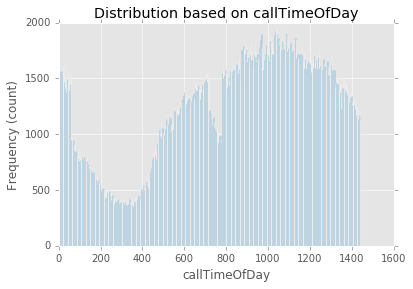

In [25]:
# create the callTimeOfDay in minutes
df["callTimeOfDay"] = df["callTime"].apply(lambda x: (int(x[:2]) * 60) + int(x[3:])) 
# Check the variability of the callTimeOfDay column
printDiff("callTimeOfDay")
graphDistribution("callTimeOfDay")

You can see a pattern in the callTime / callTimeOfDay distribution, but still not definitive enough 

Time it took to create callDay: 245.62578765432102
Difference of total records and unique callDay entries: 0
Unique callDay entries: 7
Friday       269179
Thursday     262036
Tuesday      257299
Wednesday    255177
Saturday     252369
Monday       248975
Sunday       234293
Name: callDay, dtype: int64

Distribution based on callDay
[262036, 257299, 248975, 255177, 269179, 252369, 234293]


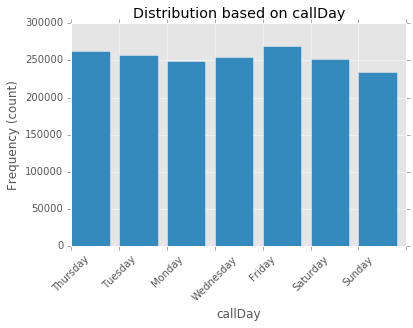

In [23]:
# Similarly, callDate's variability is too high for a decision tree (626)
# Now we need to reduce the creating the callDay column
# Note: This takes a while since there are over 1.8 million records
time1 = time.clock()
df["callDay"] = df['callDate'].apply(lambda date: pd.Timestamp(date).weekday_name)
time2 = time.clock()
print("Time it took to create callDay: " + str(time2 - time1))
printDiff("callDay")
graphDistribution("callDay")

The column callDay is not a very good classifier since the values plateau.

We are done manipulating/cleaning the callDateTime, and was able to reduce it to callHours (24 unique) and callDay (7 unique). We need to examine other columns.

In [27]:
# Now work on the districts column. Manipulate and clean the data
printDiff("district")

Difference of total records and unique district entries: 0
Unique district entries: 18
NE      262938
CD      197575
SD      193635
SE      192351
SW      192335
ND      178877
NW      176249
WD      170631
ED      166325
CW       22890
TRU      18513
SS        5714
EVT1        44
EVT2        41
INFO        10
EVT3         9
FIR1         2
HP           2
Name: district, dtype: int64


All records have a district value. However, there are a few outliers that needs to be cleaned. Several of the categories are below 0.1% of the total record count.

Time it took to run: 3.283167999999989
Difference of total records and unique district entries: 0
Unique district entries: 12
NE     262938
CD     197575
SD     193635
SE     192351
SW     192335
ND     178877
NW     176249
WD     170631
ED     166325
CW      22890
TRU     18513
SS       5714
Name: district, dtype: int64

Distribution based on district
[193635, 176249, 197575, 18513, 192335, 22890, 192351, 170631, 166325, 5714, 178877, 262938]


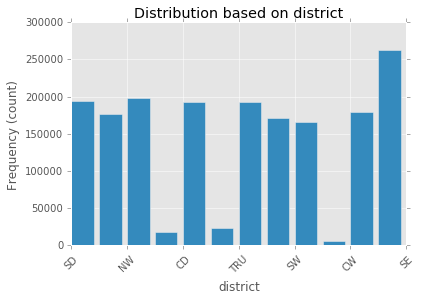

In [28]:
# Drop all the outliers based on district
time1 = time.clock()
dropRecords("district")
time2 = time.clock()
print("Time it took to run: " + str(time2-time1))
printDiff("district")
graphDistribution("district")

In [29]:
# Let us see what other columns are we working with, and try to clean up the dataset.
df.columns

Index(['callDateTime', 'priority', 'district', 'description', 'callNumber',
       'incidentLocation', 'location', 'longitude', 'latitude', 'callDate',
       'callMonth', 'callTime', 'callHour', 'callDay'],
      dtype='object')

In [30]:
# free up space
gc.collect()
# check for duplicates
print("Duplicates: " + str(len(df) - len(df.drop_duplicates())))
# drop duplicates
df.drop_duplicates(inplace = True)

# drop the columns that we don't need
df.drop(["callDateTime","description", "callNumber", "incidentLocation", "location"], axis=1, inplace=True)
df.head(10)

Duplicates: 0


,priority,district,longitude,latitude,callDate,callMonth,callTime,callHour,callDay
0,Medium,CD,39.29,-76.61,07/13/2015,07,10:41,10,Monday
1,Medium,CD,39.29,-76.61,07/13/2015,07,10:47,10,Monday
2,Medium,CD,39.29,-76.61,07/13/2015,07,10:42,10,Monday
3,Low,CD,39.30,-76.62,07/13/2015,07,10:45,10,Monday
4,Medium,SW,39.31,-76.68,07/13/2015,07,10:46,10,Monday
5,Medium,ND,39.32,-76.61,07/13/2015,07,10:47,10,Monday
6,High,WD,39.31,-76.65,07/13/2015,07,10:46,10,Monday
7,Low,SW,39.28,-76.67,07/13/2015,07,10:49,10,Monday
8,Medium,NE,39.35,-76.58,07/13/2015,07,10:48,10,Monday
9,Medium,ND,39.35,-76.67,07/13/2015,07,10:49,10,Monday


Do some final clean up.

In [31]:
# free up space
gc.collect()
# Drop records where there are NaN/null values.
print("Record count before dropna: " + str(len(df)))
df.dropna(inplace=True)
print("Record count after dropna: " + str(len(df)))

Record count before dropna: 1778033
Record count after dropna: 1778033


The dataset is now clean.

Just do the same procedure of using least square fit, and get the polynomial coefficients for the matrix.

